In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
import mdtraj
plt.rc('font', family='serif')

from msmbuilder.example_datasets import FsPeptide
dataset = FsPeptide().get()
fs_trajectories = dataset.trajectories
fs_t = fs_trajectories[0]

loading trajectory_1.xtc...
loading trajectory_10.xtc...
loading trajectory_11.xtc...
loading trajectory_12.xtc...
loading trajectory_13.xtc...
loading trajectory_14.xtc...
loading trajectory_15.xtc...
loading trajectory_16.xtc...
loading trajectory_17.xtc...
loading trajectory_18.xtc...
loading trajectory_19.xtc...
loading trajectory_2.xtc...
loading trajectory_20.xtc...
loading trajectory_21.xtc...
loading trajectory_22.xtc...
loading trajectory_23.xtc...
loading trajectory_24.xtc...
loading trajectory_25.xtc...
loading trajectory_26.xtc...
loading trajectory_27.xtc...
loading trajectory_28.xtc...
loading trajectory_3.xtc...
loading trajectory_4.xtc...
loading trajectory_5.xtc...
loading trajectory_6.xtc...
loading trajectory_7.xtc...
loading trajectory_8.xtc...
loading trajectory_9.xtc...


In [2]:
from msmbuilder.example_datasets import AlanineDipeptide
ala = AlanineDipeptide().get()
t = ala.trajectories[0]

In [3]:
from mdtraj import rmsd

In [4]:
rmsd(fs_t[:10],fs_t[0])

array([ 0.        ,  0.19644617,  0.21715195,  0.24179077,  0.2577042 ,
        0.19864696,  0.19607922,  0.20785291,  0.25813895,  0.29692328], dtype=float32)

In [5]:
def rmsd_diffs(traj,lag=10):
    ''' at each frame, calculate the rmsd to the next 10 or so frames'''
    all_rmsd_diffs = np.zeros((traj.n_frames-lag,lag))
    for i in range(len(all_rmsd_diffs)):
        all_rmsd_diffs[i] = rmsd(traj[i:(lag+i)],traj[i])
    return all_rmsd_diffs

In [6]:
diffs = rmsd_diffs(fs_t,100)

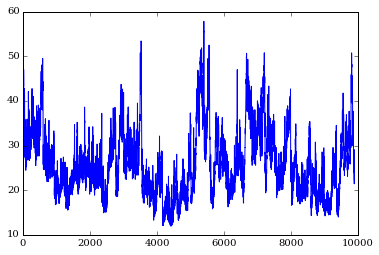

In [7]:
plt.plot(diffs.sum(1))

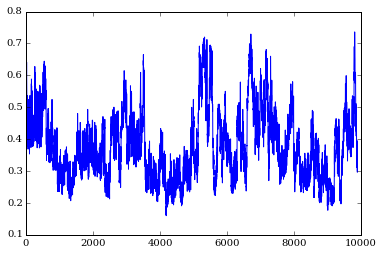

In [8]:
plt.plot(diffs.max(1))

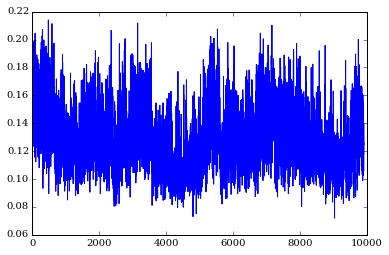

In [9]:
plt.plot(diffs[:,1:].min(1))

In [10]:
diffs.shape

(9900, 100)

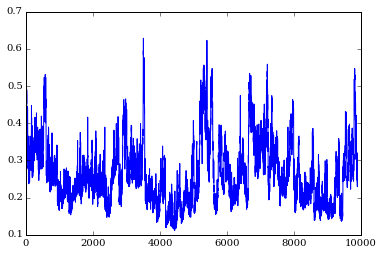

In [11]:
plt.plot(np.median(diffs[:,1:],1))

In [12]:
def ma(data,n=50):
    ''' compute moving average'''
    w = np.array([1.0/n]*n)
    return np.convolve(data,w,'valid')

In [13]:
diffs.shape

(9900, 100)

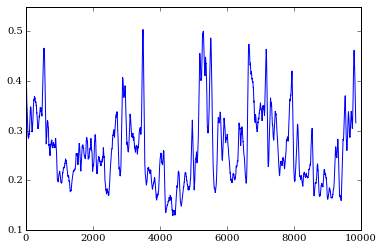

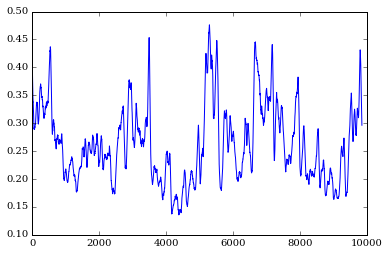

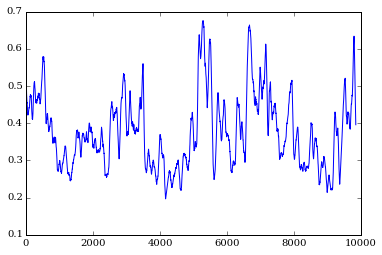

In [14]:
plt.plot(ma(np.median(diffs[:,1:],1)))
plt.figure()
plt.plot(ma(np.mean(diffs[:,1:],1)))
plt.figure()
plt.plot(ma(np.max(diffs[:,1:],1)))
#plt.plot(ma(np.min(diffs[:,1:],1)))

In [15]:
diffs_t = rmsd_diffs(t,100)

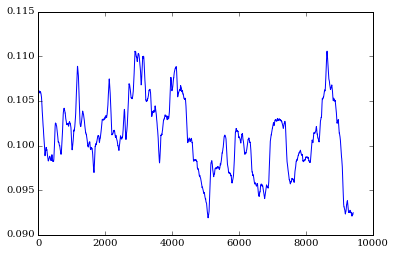

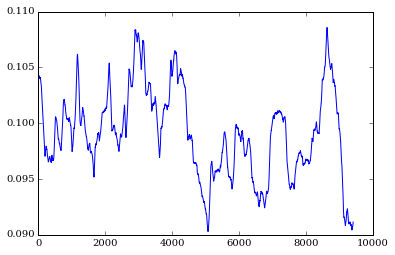

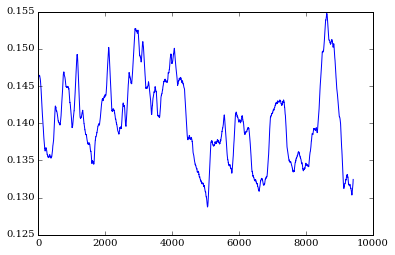

In [16]:
n=500
plt.plot(ma(np.median(diffs_t[:,1:],1),n))
plt.figure()
plt.plot(ma(np.mean(diffs_t[:,1:],1),n))
plt.figure()
plt.plot(ma(np.max(diffs_t[:,1:],1),n))
#plt.plot(ma(np.min(diffs[:,1:],1)))

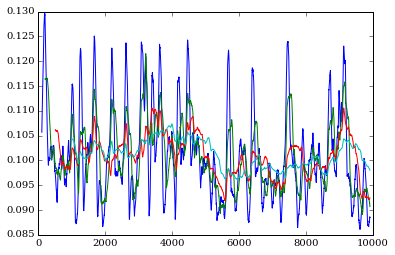

In [17]:
ns = [100,200,500,1000]
for n in ns:
    plt.plot(range(n-1,len(diffs_t)),ma(np.median(diffs_t[:,1:],1),n))

In [18]:
ma(np.median(diffs_t[:,1:],1),n).shape

(8900,)

In [19]:
n

1000

In [20]:
len(diffs_t)-n

8899

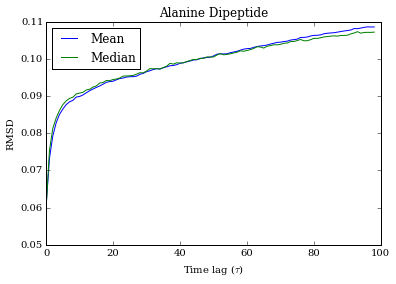

In [21]:
plt.plot(diffs_t.mean(0)[1:],label='Mean')
plt.plot(np.median(diffs_t[:,1:],0),label='Median')
#plt.plot(np.min(diffs_t[:,1:],0),label='Min')
#plt.plot(np.max(diffs_t[:,1:],0),label='Max')
plt.xlabel(r'Time lag ($\tau$)')
plt.ylabel('RMSD')
plt.legend(loc='best')
plt.title('Alanine Dipeptide')

In [22]:
diffs_t.shape

(9899, 100)

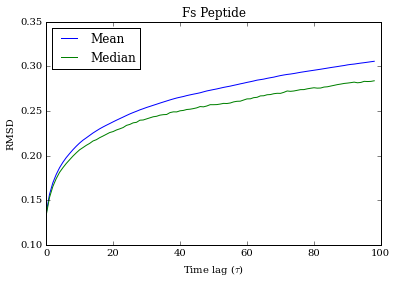

In [23]:
plt.plot(diffs.mean(0)[1:],label='Mean')
plt.plot(np.median(diffs[:,1:],0),label='Median')
#plt.plot(np.min(diffs[:,1:],0),label='Min')
#plt.plot(np.max(diffs[:,1:],0),label='Max')
plt.xlabel(r'Time lag ($\tau$)')
plt.ylabel('RMSD')
plt.legend(loc='best')
plt.title('Fs Peptide')

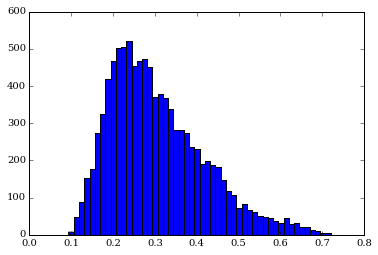

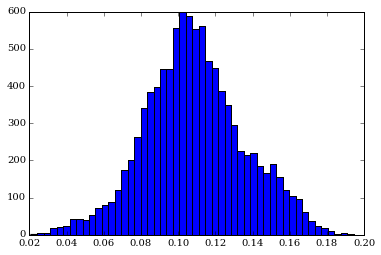

In [24]:
plt.hist(diffs[:,-1],bins=50);
plt.figure()
plt.hist(diffs_t[:,-1],bins=50);

In [25]:
import sys
sys.path.append('../projects/metric-learning')
import weighted_rmsd
reload(weighted_rmsd)

<module 'weighted_rmsd' from '../projects/metric-learning/weighted_rmsd.pyc'>

In [26]:
from weighted_rmsd import wRMSD,compute_kinetic_weights

In [204]:
weights = compute_kinetic_weights(t,10)
weights_10 = compute_kinetic_weights(t,10)
weights_100 = compute_kinetic_weights(t,100)

In [28]:
def windowed_deviations(traj,lag=100):
    ''' at each frame, calculate the atomwise deviations to the next 10 or so frames'''
    all_dev_diffs = np.zeros((traj.n_frames-lag,lag,traj.n_atoms))
    for i in range(len(all_dev_diffs)):
        for tau in range(1,lag+1):
            all_dev_diffs[i,tau-1] = weighted_rmsd.compute_atomwise_deviation(traj[i+tau],traj[i])
        if i % 1000 == 0:
            print(i)
    return all_dev_diffs

In [29]:
dev_t = windowed_deviations(t)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [30]:
dev_t.shape

(9899, 100, 22)

In [31]:
dev_t.dot(weights).shape

(9899, 100)

In [32]:
%timeit dev_t.dot(weights)

10 loops, best of 3: 34.8 ms per loop


In [47]:
weights = (weights/np.sqrt(sum(weights**2)))
weights.mean()

0.18414783968453527

In [63]:
def norm(w):
    return w/np.sqrt(np.sum(w**2))

In [48]:
def plot_diffs(diffs,title='',label=''):
    if len(label)>0:
        plt.plot(diffs.mean(0)[1:],label=label)
    else:
        plt.plot(diffs.mean(0)[1:])
    plt.xlabel(r'Time lag ($\tau$)')
    plt.ylabel('RMSD')

    if len(title)>0:
        plt.title(title)

In [49]:
n_atoms = len(weights)

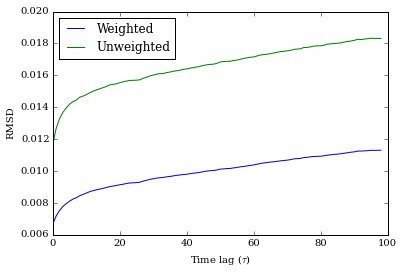

In [52]:
plot_diffs(dev_t.dot(norm(weights))/n_atoms,label='Weighted')
plot_diffs(dev_t.dot(norm(np.ones(dev_t.shape[-1])))/n_atoms,label='Unweighted')
#plot_diffs(diffs,label='Unweighted')
plt.legend(loc='best')

In [116]:
def objective(weights):
    normalized_weights = norm(weights)
    return np.sum(np.dot(dev_t,normalized_weights)**2)*np.min(weights >= 0)

In [117]:
def lnprob(weights):
    return -np.log(objective(weights))

In [118]:
ones = np.ones(len(weights))
print(objective(ones),objective(weights))
print(lnprob(ones),lnprob(weights))

(142357.34728641112, 53677.060161727517)
(-11.866095705609629, -10.890741004157169)


In [119]:
%timeit objective(weights)

10 loops, best of 3: 35.2 ms per loop


In [120]:
import emcee

In [121]:
weights.shape

(22,)

In [122]:
lnprob(weights+npr.randn(n_atoms)*0.01)

-10.871543027811178

In [123]:
from autograd import grad
import autograd.numpy as np

In [113]:
grad_objective = grad(objective)

In [114]:
grad_objective(weights)

array([ 53223.56740511, -17864.30448145,  53366.86830639,  53259.49151462,
       -11385.08108938,  29740.02818509, -23251.88545877,  15193.74002534,
       -29306.54675912,  -8842.7257977 , -17290.10163157,  31061.0076599 ,
        30729.35418509,  30585.41374849, -11605.92230607,  39055.97039275,
       -14518.18901346,  29112.47084265, -13450.6359189 ,  53865.61097045,
        53557.65771912,  53769.56297641])

In [130]:
n_walkers = n_atoms*2
sampler = emcee.EnsembleSampler(n_walkers, n_atoms, lambda w:-objective(w))
sampler.run_mcmc(np.random.randn(n_walkers,n_atoms), 100)

(array([[  2.04838002e+19,   1.09791106e+19,  -2.40203009e+18,
           1.47598905e+19,  -2.37245109e+19,   4.46252773e+18,
          -1.20075333e+19,  -3.47695230e+18,  -1.13709004e+19,
           1.58534115e+18,  -2.39525681e+18,  -1.63931874e+19,
           4.96616941e+18,  -1.41884309e+19,  -1.25881750e+19,
          -1.45922105e+19,   1.08999834e+19,  -7.36863242e+18,
           4.35265354e+18,   1.57625999e+19,   1.55486221e+19,
          -9.69565931e+18],
        [  7.38589319e+19,   3.95876571e+19,  -8.66109871e+18,
           5.32200709e+19,  -8.55440268e+19,   1.60906640e+19,
          -4.32958544e+19,  -1.25369218e+19,  -4.10003237e+19,
           5.71630094e+18,  -8.63664965e+18,  -5.91093170e+19,
           1.79066463e+19,  -5.11595317e+19,  -4.53894765e+19,
          -5.26154607e+19,   3.93023493e+19,  -2.65692481e+19,
           1.56944894e+19,   5.68356041e+19,   5.60640377e+19,
          -3.49598815e+19],
        [  9.51447067e+19,   5.09966035e+19,  -1.11571230e+19,

In [131]:
sampler.flatchain.shape

(4400, 22)

In [132]:
normed_chain = np.array([norm(s) for s in sampler.flatchain])

In [133]:
normed_chain

array([[-0.15196116,  0.53463089,  0.05975893, ...,  0.20109551,
         0.19115583, -0.08688488],
       [-0.13607448,  0.50745558,  0.04680355, ...,  0.18634484,
         0.18072572, -0.07982799],
       [-0.13607448,  0.50745558,  0.04680355, ...,  0.18634484,
         0.18072572, -0.07982799],
       ..., 
       [-0.35751461, -0.19162426,  0.04192417, ..., -0.27511308,
        -0.27137828,  0.16922351],
       [-0.35751461, -0.19162426,  0.04192417, ..., -0.27511308,
        -0.27137828,  0.16922351],
       [-0.35751459, -0.19162425,  0.04192405, ..., -0.27511304,
        -0.27137829,  0.16922349]])

In [128]:
import triangle
reload(triangle)

<module 'triangle' from '/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/triangle.pyc'>

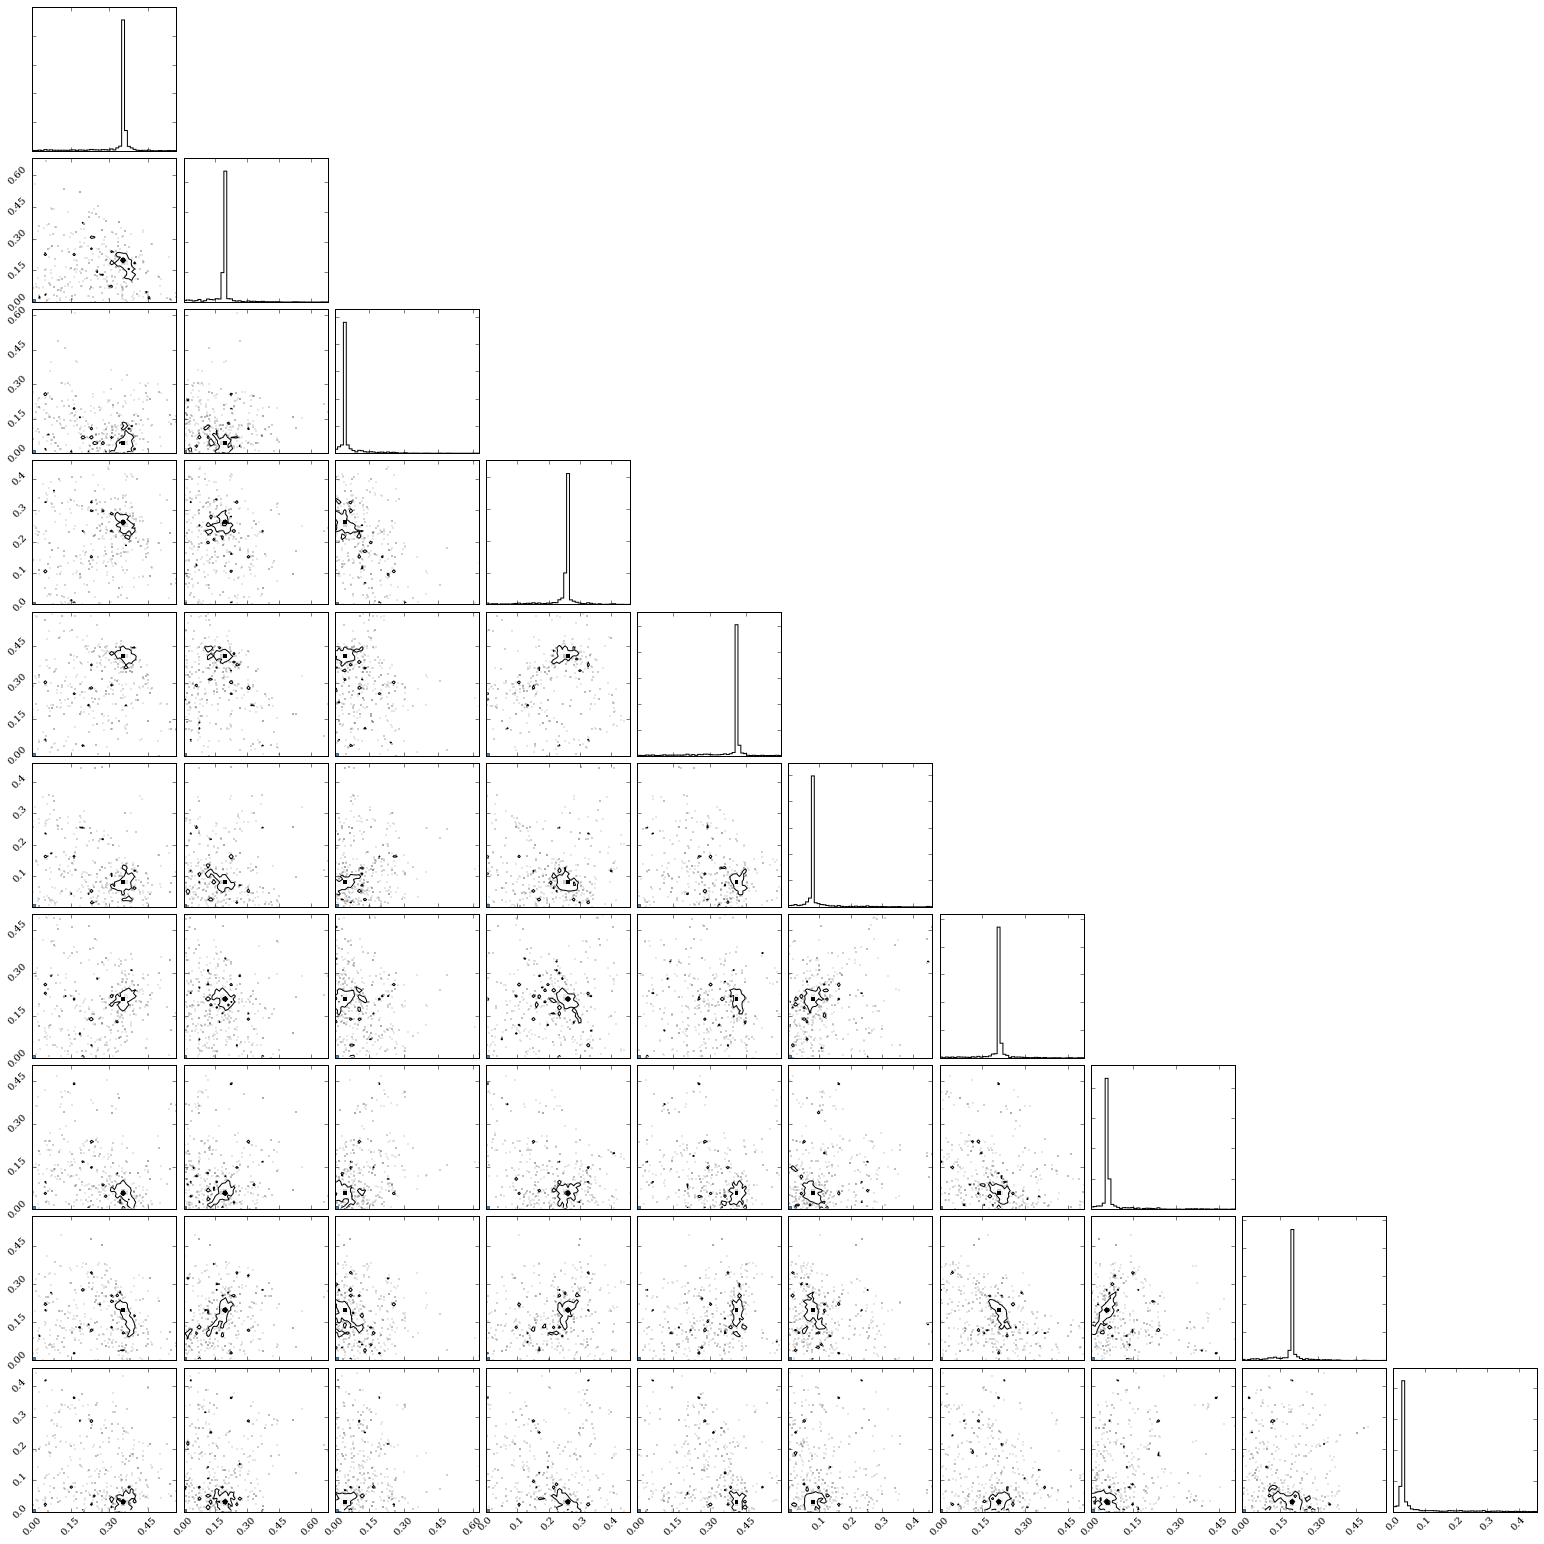

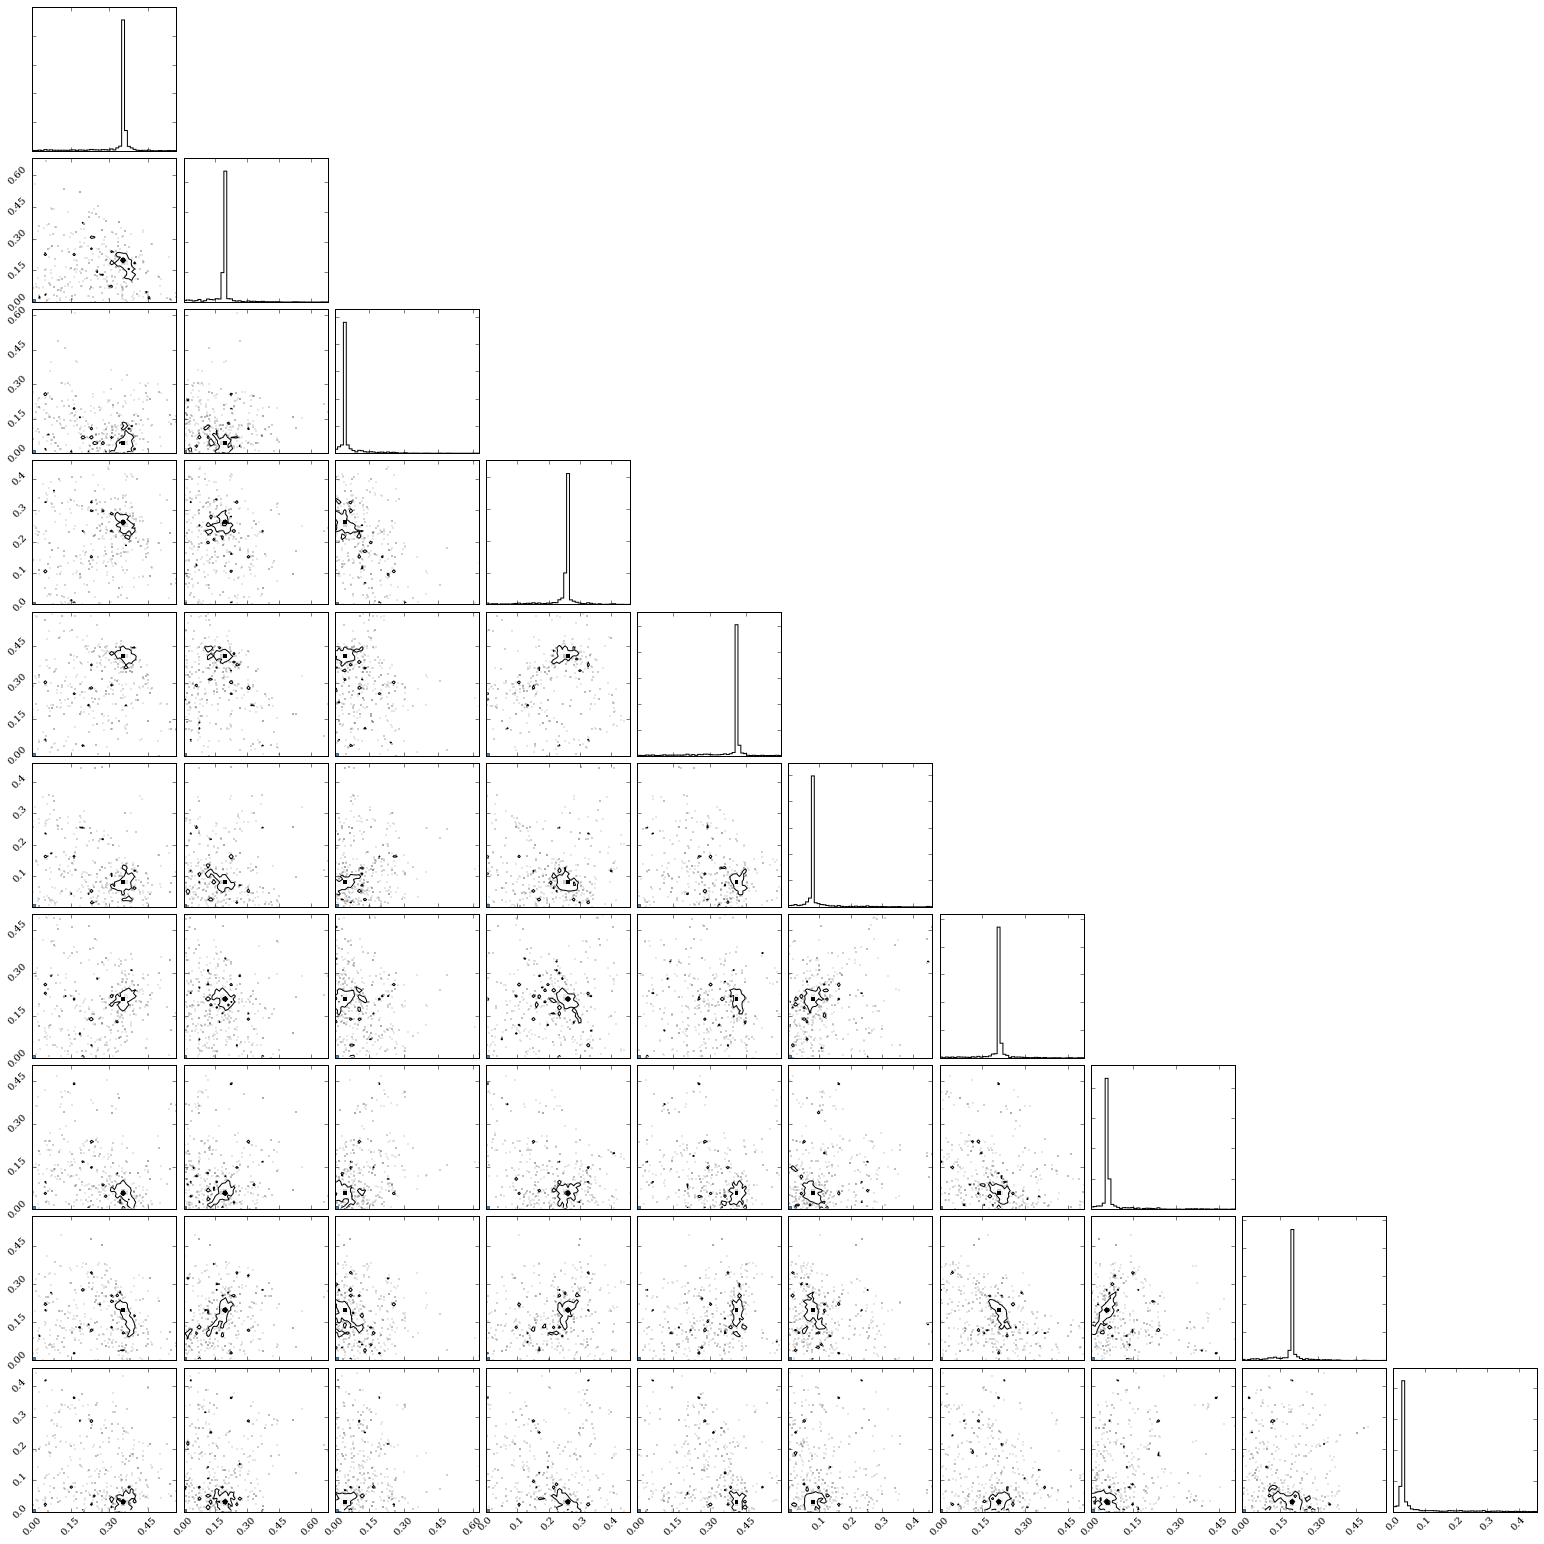

In [135]:
samples = np.abs(normed_chain[1000:,:10])
triangle.corner(samples,truths=np.zeros(samples.shape[1]))

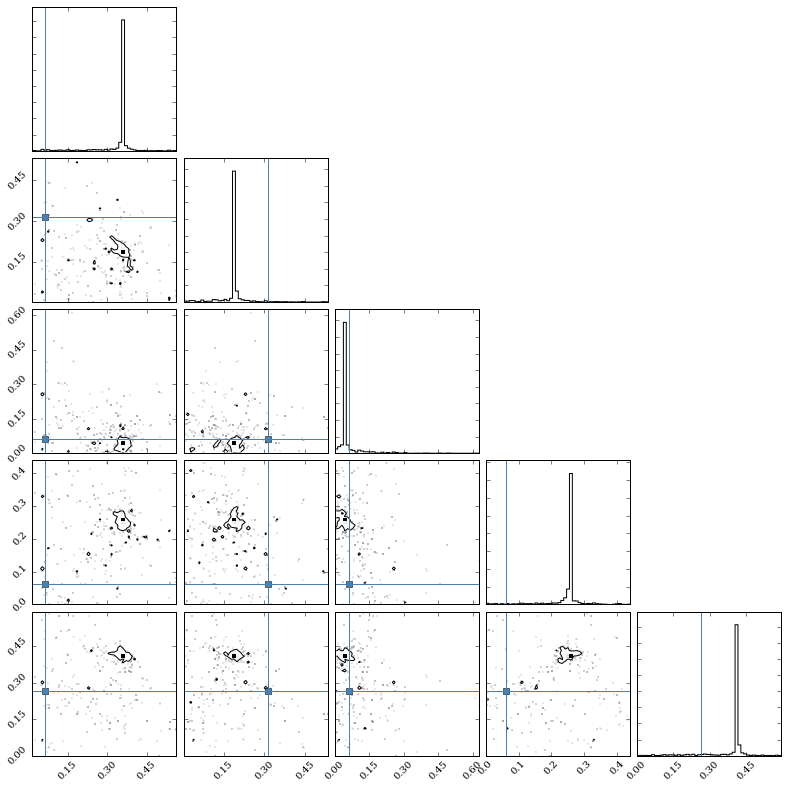

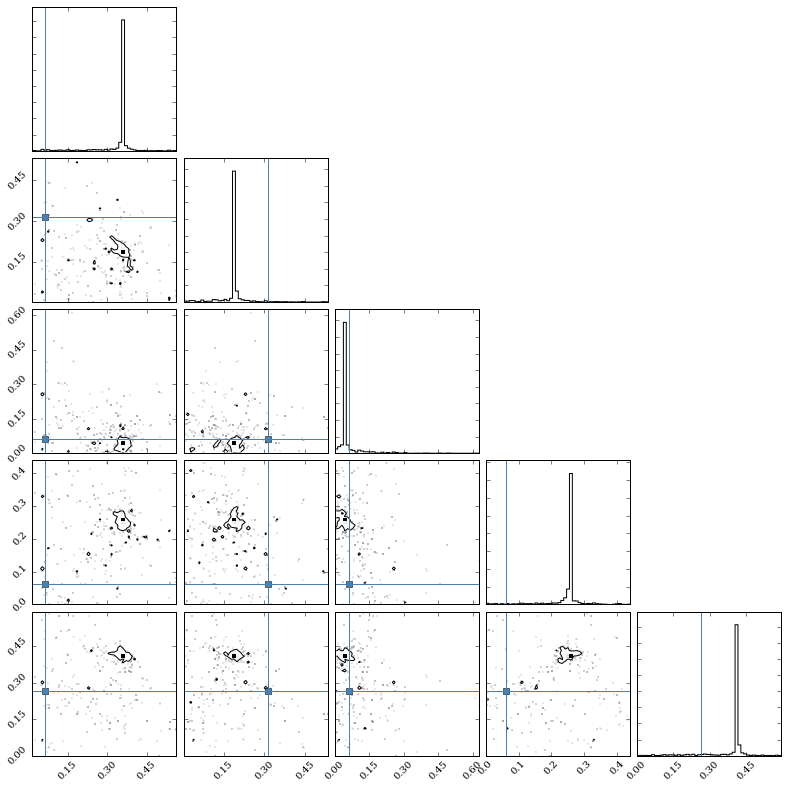

In [162]:
samples = np.abs(normed_chain[len(normed_chain)/2:,:5])
triangle.corner(samples,truths=weights[:samples.shape[1]])

In [97]:
objs = [objective(s) for s in normed_chain[-500:]]

In [100]:
np.argmin(objs)

497

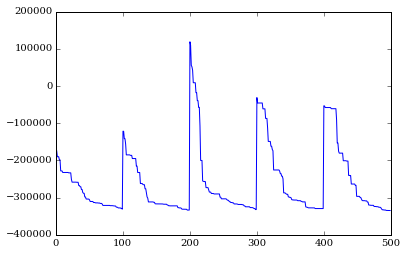

In [101]:
plt.plot(objs)

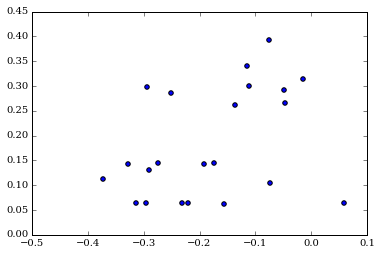

In [103]:
plt.scatter(normed_chain[-1],norm(weights))

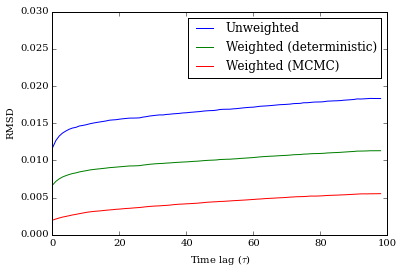

In [157]:
plot_diffs(np.abs(dev_t.dot(norm(np.ones(dev_t.shape[-1])))/n_atoms),label='Unweighted')
plot_diffs(dev_t.dot(norm(weights))/n_atoms,label='Weighted (deterministic)')
for i in range(1,2):
    plot_diffs(np.abs(dev_t.dot(norm(normed_chain[-i*100]))/n_atoms),label='Weighted (MCMC)')
#plot_diffs(diffs,label='Unweighted')
plt.ylim(0,0.03)
plt.legend(loc='best')

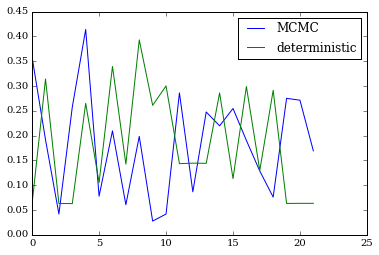

In [161]:
plt.plot(np.abs(normed_chain[-1]),label='MCMC')
plt.plot(weights,label='deterministic')
plt.legend()

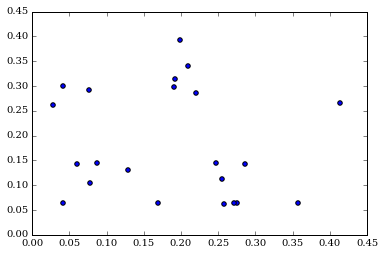

In [151]:
plt.scatter(np.abs(normed_chain[-1]),weights)

In [163]:
t

<mdtraj.Trajectory with 9999 frames, 22 atoms, 3 residues, without unitcells at 0x106810ad0>

In [169]:
from msmbuilder import featurizer
rpf = featurizer.RawPositionsFeaturizer()
rpft = np.array(rpf.fit_transform(t.center_coordinates())).reshape((len(t),n_atoms,3))

In [170]:
n=1000
dev_mat = np.zeros((n,n,n_atoms))
for i in range(len(t)-1):
    for j in range(i):
        dev_mat[i,j] = weighted_rmsd.compute_atomwise_deviation_xyz(rpft[i*10],rpft[j*10])
    if i%100==0:
        print(i)

0
100
200
300
400
500
600
700
800
900


IndexError: index 10000 is out of bounds for axis 0 with size 9999

In [198]:
def distmat_plot(dist_mat_raw):
    dist_mat = dist_mat_raw + dist_mat_raw.T
    plt.imshow(dist_mat,interpolation='none',cmap='Blues')

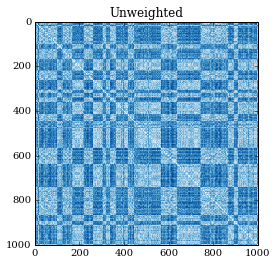

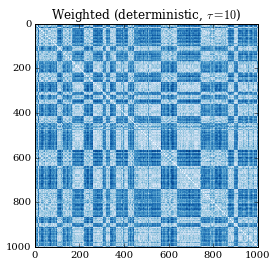

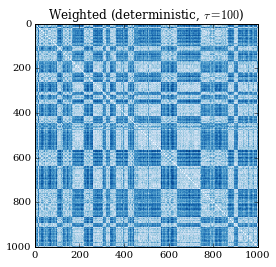

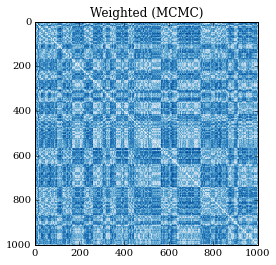

In [205]:
distmat_plot(dev_mat.dot(ones))
plt.title('Unweighted')
plt.savefig('ala_unweighted.pdf')

plt.figure()
distmat_plot(dev_mat.dot(weights_10))
plt.title(r'Weighted (deterministic, $\tau=10$)')
plt.savefig('ala_weighted_det_10.pdf')

plt.figure()
distmat_plot(dev_mat.dot(weights_100))
plt.title(r'Weighted (deterministic, $\tau=100$)')
plt.savefig('ala_weighted_det_100.pdf')

plt.figure()
distmat_plot(np.abs(dev_mat.dot(np.abs(normed_chain[-1000]))))
plt.title('Weighted (MCMC)')
plt.savefig('ala_weighted_mcmc.pdf')

In [177]:
dev_mat.shape

(1000, 1000, 22)

In [178]:
dev_mat.dot(weights).shape

(1000, 1000)

In [ ]:
plt.imshow(dev_mat.dot(weights))